In [46]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import ast
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from evaluate_ec import evaluate_ec_predictions
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns
from collections import defaultdict
import os
import sys
sys.modules["numpy._core.numeric"] = np.core.numeric

## Loading data

In [47]:
train_df = pd.read_pickle("../dataset/all_features/train.pkl")
valid_df = pd.read_pickle("../dataset/all_features/valid.pkl")
test_df = pd.read_pickle("../dataset/all_features/test.pkl")

In [48]:
train_df

,molecular_weight,isoelectric_point,gravy,aromaticity,instability_index,aliphatic_index,boman_index,ec_0,ec_1,ec_2,...,pssm_1334,pssm_1335,pssm_1336,pssm_1337,pssm_1338,pssm_1339,pssm_1340,pssm_1341,pssm_1342,pssm_1343
0,32275.0348,8.347963,-0.154483,0.058621,42.982793,105.862069,0.291586,2,5,1,...,0.0,0.0,7.0,7.0,3.0,4.0,0.0,0.0,0.55,0.27
1,529990.8042,6.424364,-0.162032,0.053542,46.634426,90.848941,0.260615,2,3,2,...,1.0,2.0,3.0,4.0,3.0,1.0,2.0,35.0,0.04,0.01
2,527221.8439,5.875981,-0.186202,0.060612,42.951614,90.877120,0.276119,2,3,2,...,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.19,0.02
3,37082.7180,5.953111,-0.295385,0.089231,50.063692,94.553846,0.349231,2,5,1,...,4.0,1.0,0.0,0.0,0.0,0.0,1.0,11.0,1.05,0.35
4,73292.5257,8.690096,0.295475,0.110106,38.304540,110.030166,0.535460,2,3,1,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.34,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45755,62736.3791,9.224539,-0.222993,0.094891,37.310420,96.733577,0.360274,3,6,4,...,0.0,1.0,65.0,6.0,1.0,0.0,1.0,0.0,1.73,0.74
45756,81911.2453,8.032326,-0.263022,0.133813,38.216604,95.251799,0.419914,3,6,4,...,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.43,0.01
45757,25398.5248,5.070572,-0.309459,0.094595,31.677928,91.036036,0.396667,3,1,3,...,0.0,0.0,1.0,17.0,1.0,0.0,0.0,1.0,0.25,0.07
45758,18860.1921,5.420075,-0.202367,0.053254,45.992367,102.721893,0.323846,3,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.05,0.15


In [49]:
test_df

,molecular_weight,isoelectric_point,gravy,aromaticity,instability_index,aliphatic_index,boman_index,ec_0,ec_1,ec_2,...,pssm_1334,pssm_1335,pssm_1336,pssm_1337,pssm_1338,pssm_1339,pssm_1340,pssm_1341,pssm_1342,pssm_1343
0,31244.5963,6.589935,-0.292701,0.083942,35.858029,94.708029,0.351971,3,6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.82,0.14
1,91703.7386,7.501406,-0.608922,0.095415,48.009170,68.859975,0.175068,3,1,3,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.43,0.04
2,85429.3523,8.992518,-0.547197,0.059974,42.901838,81.186441,0.096988,3,6,4,...,0.0,0.0,16.0,14.0,3.0,0.0,1.0,1.0,0.34,0.16
3,238520.6175,8.151592,-0.347029,0.058032,46.601862,87.400186,0.206356,3,6,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.01
4,32652.1900,9.253421,-0.484752,0.117021,27.952163,86.099291,0.292021,3,1,26,...,7.0,1.0,5.0,2.0,4.0,2.0,11.0,6.0,0.15,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,32403.6261,6.557480,-0.588850,0.062718,37.762718,82.857143,0.186585,2,7,1,...,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.38,0.02
8177,50614.7558,5.565185,-0.030110,0.083516,34.673407,95.186813,0.413341,2,4,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.22,0.52
8178,32683.2839,6.855999,-0.028136,0.067797,30.228136,109.084746,0.374508,2,1,1,...,0.0,98.0,0.0,0.0,0.0,0.0,2.0,0.0,3.40,0.98
8179,45490.2139,7.631908,-0.233171,0.082927,24.039537,87.292683,0.338293,2,7,7,...,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.41,0.04


## Data Processing

In [50]:
def get_feature_and_label(df):
    ec_cols = [col for col in df.columns if col.startswith('ec_')]
    return df.drop(columns=ec_cols), df[ec_cols]

In [51]:
train_X, train_Y = get_feature_and_label(train_df)
valid_X, valid_Y = get_feature_and_label(valid_df)
test_X, test_Y = get_feature_and_label(test_df)

scaler = MinMaxScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)
valid_X = scaler.transform(valid_X)
test_X = scaler.transform(test_X)

In [52]:
train_Y

,ec_0,ec_1,ec_2,ec_3
0,2,5,1,61
1,2,3,2,26
2,2,3,2,26
3,2,5,1,83
4,2,3,1,78
...,...,...,...,...
45755,3,6,4,13
45756,3,6,4,12
45757,3,1,3,5
45758,3,1,4,-1


# Modeling

In [53]:
def multioutput_f1_score(y_true, y_pred):
    # Flatten all outputs and compute micro-F1
    return f1_score(y_true.ravel(), y_pred.ravel(), average='micro', zero_division=0)

In [54]:
X_trainval = np.concatenate([train_X, valid_X], axis=0)
y_trainval = np.concatenate([train_Y, valid_Y], axis=0)
split_index = np.concatenate([
    np.full(len(train_X), -1),  # Training samples (-1 means they are used for training)
    np.full(len(valid_X), 0)    # Validation samples (0 means they are used for validation)
])
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)
f1_scorer = make_scorer(multioutput_f1_score)

In [10]:
# !python feature_selection.py

In [55]:
with open("grid_scores.pkl", "rb") as f:
    cv_results = pickle.load(f)

with open("final_indices.pkl", "rb") as f:
    final_indices = pickle.load(f)
    
X_trainval = X_trainval[:, final_indices]
test_X = test_X[:, final_indices]
optimal_n_features = len(final_indices) 

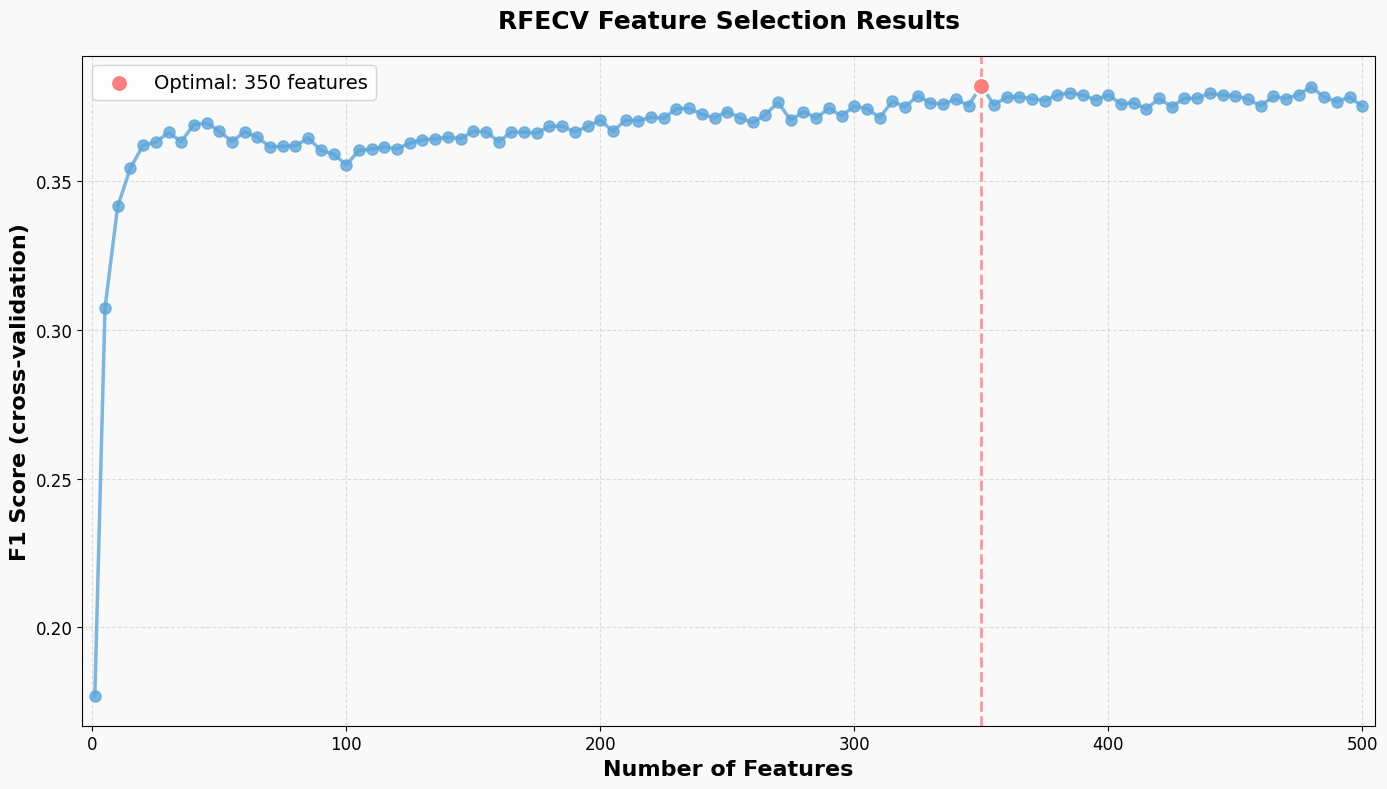

Optimal number of features: 350
Optimal F1 score: 0.3820


In [57]:
# Extract the number of features and corresponding scores
# The exact key name might vary depending on how cv_results is structured
if 'mean_test_score' in cv_results:
    mean_scores = cv_results['mean_test_score']
elif 'mean_score' in cv_results:
    mean_scores = cv_results['mean_score']
else:
    # Try to find the key containing scores
    score_keys = [key for key in cv_results.keys() if 'score' in key]
    if score_keys:
        mean_scores = cv_results[score_keys[0]]
    else:
        # If RFECV saved grid_scores directly
        mean_scores = cv_results

# Load the optimal number of features
with open("final_indices.pkl", "rb") as f:
    final_indices = pickle.load(f)
    optimal_n_features = len(final_indices)

# Create x-axis values (number of features at each step)
# If this information is in cv_results, extract it
if 'n_features' in cv_results:
    n_features = cv_results['n_features']
else:
    # Otherwise reconstruct based on step size and number of features
    # This is an approximation based on your original feature count
    step_size = 5  # As specified in your RFECV parameters
    n_features = np.arange(step_size, 501, step_size)  # Only go up to 500 as requested
    if len(n_features) != len(mean_scores):
        # Adjust to match the length of mean_scores
        n_features = np.linspace(step_size, 500, len(mean_scores)).astype(int)

# Create the visualization with improved styling
plt.figure(figsize=(14, 8))
plt.plot(n_features, mean_scores, 'o-', color='#5DA5DA', linewidth=2.5, markersize=8, alpha=0.8)
plt.xlabel('Number of Features', fontsize=16, fontweight='bold')
plt.ylabel('F1 Score (cross-validation)', fontsize=16, fontweight='bold')
plt.title('RFECV Feature Selection Results', fontsize=18, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.4)

# Mark the optimal number of features
optimal_idx = np.where(n_features >= optimal_n_features)[0][0] if any(n_features >= optimal_n_features) else -1
if optimal_idx >= 0:
    plt.axvline(x=n_features[optimal_idx], color='#FF7F7F', linestyle='--', alpha=0.8, linewidth=2)
    plt.scatter([n_features[optimal_idx]], [mean_scores[optimal_idx]], 
                color='#FF7F7F', s=150, zorder=5, edgecolor='white', linewidth=1.5,
                label=f'Optimal: {optimal_n_features} features')

# Improve the appearance of the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='#CCCCCC')

# Add some padding to the axes
plt.xlim(min(n_features) - 5, 505)
plt.ylim(min(mean_scores) - 0.01, max(mean_scores) + 0.01)

# Make the background slightly off-white for a nicer look
plt.gca().set_facecolor('#F9F9F9')
plt.gcf().set_facecolor('#F9F9F9')

plt.tight_layout()
plt.savefig('rfecv_feature_selection.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Optimal number of features: {optimal_n_features}")
if optimal_idx >= 0:
    print(f"Optimal F1 score: {mean_scores[optimal_idx]:.4f}")

In [58]:
X_trainval.shape

(53071, 350)

### Single Random Forest

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# Set up the RandomForestClassifier (no MultiOutputClassifier needed)

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=pds,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_trainval, y_trainval)

# Best parameters and best F1 score
print("Best params:", grid_search.best_params_)
print("Best F1:", grid_search.best_score_)

In [ ]:
# Evaluate on the test set
# best_params = grid_search.best_params_
# best_model = RandomForestClassifier(random_state=42, **best_params)
best_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None)
best_model.fit(X_trainval, y_trainval)

In [ ]:
test_pred = best_model.predict(test_X)
final_f1 = multioutput_f1_score(test_Y.to_numpy(), test_pred)
print("Test F1:", final_f1)
eval_report = evaluate_ec_predictions(test_pred, test_Y.to_numpy(), "Selected Features + RF")
eval_report

Test F1: 0.40367925681457034


,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,Physiochemical + HMM + Peptides + PSSM + RF,0.067718,0.0,0.0,0.453979,0.333541,0.759008,0.33233,0.405696,0.119101,0.294561,0.13611,0.497372,0.06789,0.321592,0.079612,0.063195,0.706811,0.715351,0.709565


In [13]:
metrics = pd.read_csv('../metrics/experiment_results.csv')
report_combined = pd.concat([metrics, eval_report], axis=0, ignore_index=True)
display(report_combined)
report_combined.to_csv('../metrics/experiment_results.csv', index=False)

,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,Diamond Benchmark,0.039201,0.941015,0.941015,0.055688,0.721168,0.037458,0.070890,0.053306,0.486238,0.031849,0.058538,0.049460,0.586344,0.039202,0.072057,0.039201,0.275194,0.044003,0.068529
1,Physiochemical + HMM + RF,0.045349,0.000000,0.000000,0.428798,0.308276,0.728130,0.301557,0.374160,0.106004,0.313204,0.119088,0.484537,0.056081,0.316874,0.060274,0.044616,0.458614,0.523714,0.474899
2,Physiochemical + HMM + MultiRF,0.035204,0.000000,0.000000,0.420609,0.297715,0.720197,0.285135,0.364992,0.098482,0.356674,0.108555,0.489060,0.064475,0.313242,0.074011,0.201809,0.055158,0.203867,0.072607
3,Physiochemical + HMM + Peptides + RF,0.070774,0.000000,0.000000,0.461313,0.347138,0.694721,0.351522,0.412541,0.134055,0.411474,0.159142,0.498105,0.073154,0.399611,0.089062,0.062951,0.606769,0.651824,0.620800
4,Physiochemical + HMM + Peptides + CascadeRF,0.095954,0.000000,0.000000,0.458624,0.343595,0.714645,0.346260,0.398362,0.132142,0.396339,0.150091,0.514240,0.095252,0.412118,0.120354,0.263415,0.118571,0.246855,0.135757
5,Physiochemical + HMM + Peptides + PSSM + RF,0.067718,0.000000,0.000000,0.453979,0.333541,0.759008,0.332330,0.405696,0.119101,0.294561,0.136110,0.497372,0.067890,0.321592,0.079612,0.063195,0.706811,0.715351,0.709565
6,Physiochemical + HMM + Peptides + PSSM + RF,0.067718,0.000000,0.000000,0.453979,0.333541,0.759008,0.332330,0.405696,0.119101,0.294561,0.136110,0.497372,0.067890,0.321592,0.079612,0.063195,0.706811,0.715351,0.709565


### Cascade Modelling

In [ ]:
# !python model_selection.py

In [38]:
# Ensure necessary directories exist
models_folder = "Models"
results_base_folder = "../metrics"
os.makedirs(results_base_folder, exist_ok=True)

# Create organized subfolder structure
confusion_matrix_folder = os.path.join(results_base_folder, "confusion_matrices")
roc_curves_folder = os.path.join(results_base_folder, "roc_curves")
reports_folder = os.path.join(results_base_folder, "evaluation_reports")

# Create all necessary folders
for folder in [confusion_matrix_folder, roc_curves_folder, reports_folder]:
    os.makedirs(folder, exist_ok=True)

# Initialize global storage for ROC data comparison
roc_comparison_data = defaultdict(lambda: {
    'model_names': [],
    'fprs': [],
    'tprs': [],
    'auc_scores': []
})

all_eval_reports = None

# Get all model files from the directory
pkl_files = [f for f in os.listdir(models_folder) if f.endswith(".pkl")]

# Process each model file
for pkl_file in pkl_files:
    model_path = os.path.join(models_folder, pkl_file)
    model_name = f"{os.path.splitext(pkl_file)[0]}"
    print(f"Processing model file: {pkl_file}")
    
    # Create model-specific subfolders
    model_cm_folder = os.path.join(confusion_matrix_folder, model_name)
    model_roc_folder = os.path.join(roc_curves_folder, model_name)
    os.makedirs(model_cm_folder, exist_ok=True)
    os.makedirs(model_roc_folder, exist_ok=True)
    
    # Load trained cascade models
    with open(model_path, "rb") as f:
        models = pickle.load(f)

    # --------------------------
    # Cascade Prediction
    # --------------------------
    cascade_test_features = test_X.copy()
    test_preds_list = []  # Store predicted labels
    roc_probs_list = []   # Store probability matrices
    num_outputs = test_Y.shape[1]

    # Generate predictions through cascade
    for i in tqdm(range(len(models)), desc=f"Cascade Prediction for {pkl_file}"):
        try:
            prob_matrix = models[i].predict_proba(cascade_test_features)
        except Exception as e:
            print(f"Error in predict_proba for model index {i}: {e}")
            prob_matrix = np.zeros((len(cascade_test_features), 2))
        roc_probs_list.append(prob_matrix)

        try:
            y_pred_col = models[i].predict(cascade_test_features)
        except Exception as e:
            print(f"Error in prediction for model index {i}: {e}")
            y_pred_col = -1 * np.ones(len(cascade_test_features), dtype=int)

        test_preds_list.append(y_pred_col)
        cascade_test_features = np.hstack([cascade_test_features, y_pred_col.reshape(-1, 1)])

    test_pred = np.column_stack(test_preds_list)

    # Evaluate model performance
    eval_report = evaluate_ec_predictions(
        test_pred,
        test_Y.to_numpy(),
        method_name=f"Physiochemical + HMM + Peptides + PSSM + {model_name}"
    )

    # Save individual report
    model_report_path = os.path.join(reports_folder, f"{model_name}_eval_report.csv")
    eval_report.to_csv(model_report_path, index=False)
    print(f"Saved evaluation report to {model_report_path}")

    # Aggregate reports
    if all_eval_reports is None:
        all_eval_reports = eval_report
    else:
        all_eval_reports = pd.concat([all_eval_reports, eval_report], axis=0, ignore_index=True)

    # --------------------------
    # Confusion Matrix Plotting
    # --------------------------
    for i in range(num_outputs):
        y_true = test_Y.to_numpy()[:, i]
        y_pred = test_pred[:, i]
        mask = (y_true != -1)
        y_true_filtered = y_true[mask]
        y_pred_filtered = y_pred[mask]

        unique_labels = np.unique(np.concatenate([y_true_filtered, y_pred_filtered]))
        unique_labels = np.sort(unique_labels)

        cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=unique_labels)

        # Normalize confusion matrix
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_normalized = np.divide(
            cm.astype(float), row_sums,
            out=np.zeros_like(cm, dtype=float),
            where=(row_sums != 0)
        )

        # Filter empty rows/columns
        non_empty_rows = cm_normalized.sum(axis=1) != 0
        non_empty_cols = cm_normalized.sum(axis=0) != 0
        cm_normalized = cm_normalized[non_empty_rows][:, non_empty_cols]
        labels_row = unique_labels[non_empty_rows]
        labels_col = unique_labels[non_empty_cols]

        # Dynamic figure sizing
        fig_width = min(2 + 0.5 * len(labels_col), 25)
        fig_height = min(2 + 0.5 * len(labels_row), 25)

        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=labels_col,
            yticklabels=labels_row
        )
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {model_name} - Output EC_{i}")
        plt.tight_layout()

        cm_filename = os.path.join(model_cm_folder, f"ConfusionMatrix_OutputEC_{i}.png")
        plt.savefig(cm_filename)
        plt.close()
        print(f"Saved confusion matrix for {pkl_file}, output EC_{i} to {cm_filename}")

    # --------------------------
    # ROC Curve Plotting
    # --------------------------
    for i in range(num_outputs):
        y_true_col = test_Y.iloc[:, i].to_numpy()
        mask = y_true_col != -1
        y_true_filtered = y_true_col[mask]
        
        # Skip invalid cases
        if len(y_true_filtered) == 0 or len(np.unique(y_true_filtered)) < 2:
            print(f"Skipping ROC for {pkl_file}, Output EC_{i}: insufficient samples.")
            continue

        # Process probabilities
        model_i = models[i]
        prob_matrix = roc_probs_list[i][mask, :]
        classes = model_i.classes_
    
        # Filter invalid labels
        valid_labels = np.isin(y_true_filtered, classes)
        if not np.all(valid_labels):
            y_true_filtered = y_true_filtered[valid_labels]
            prob_matrix = prob_matrix[valid_labels]
        
        if len(y_true_filtered) < 2:
            print(f"Skipping ROC for {pkl_file}, Output EC_{i}: insufficient valid samples.")
            continue
    
        # Binarize labels
        y_true_bin = label_binarize(y_true_filtered, classes=classes)
        
        # Calculate micro-average ROC
        fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), prob_matrix.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        
        # Store data for comparison
        roc_comparison_data[i]['model_names'].append(model_name)
        roc_comparison_data[i]['fprs'].append(fpr_micro)
        roc_comparison_data[i]['tprs'].append(tpr_micro)
        roc_comparison_data[i]['auc_scores'].append(roc_auc_micro)

        # Plot individual ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_micro, tpr_micro, 
                 label=f'Micro-avg (AUC = {roc_auc_micro:.2f})',
                 color='deeppink', linestyle=':', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC for {model_name} - EC_{i}")
        plt.legend(loc="lower right")
        
        roc_filename = os.path.join(model_roc_folder, f"ROC_EC_{i}.png")
        plt.savefig(roc_filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved ROC curve: {roc_filename}")

Processing model file: cascade_models_CatBoost.pkl


Cascade Prediction for cascade_models_CatBoost.pkl: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


Saved evaluation report to ../metrics/evaluation_reports/cascade_models_CatBoost_eval_report.csv
Saved confusion matrix for cascade_models_CatBoost.pkl, output EC_0 to ../metrics/confusion_matrices/cascade_models_CatBoost/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_CatBoost.pkl, output EC_1 to ../metrics/confusion_matrices/cascade_models_CatBoost/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_CatBoost.pkl, output EC_2 to ../metrics/confusion_matrices/cascade_models_CatBoost/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_CatBoost.pkl, output EC_3 to ../metrics/confusion_matrices/cascade_models_CatBoost/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_CatBoost/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_CatBoost/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_CatBoost/ROC_EC_2.png
Saved ROC curve: ../metrics/roc_curves/cascade_mode

Cascade Prediction for cascade_models_KNN.pkl: 100%|██████████| 4/4 [00:29<00:00,  7.38s/it]


Saved evaluation report to ../metrics/evaluation_reports/cascade_models_KNN_eval_report.csv
Saved confusion matrix for cascade_models_KNN.pkl, output EC_0 to ../metrics/confusion_matrices/cascade_models_KNN/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_KNN.pkl, output EC_1 to ../metrics/confusion_matrices/cascade_models_KNN/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_KNN.pkl, output EC_2 to ../metrics/confusion_matrices/cascade_models_KNN/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_KNN.pkl, output EC_3 to ../metrics/confusion_matrices/cascade_models_KNN/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_KNN/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_KNN/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_KNN/ROC_EC_2.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_KNN/ROC_EC_3.png
Processing model file: cascade_models_Lo

Cascade Prediction for cascade_models_LogisticRegression.pkl: 100%|██████████| 4/4 [00:00<00:00, 18.59it/s]


Saved evaluation report to ../metrics/evaluation_reports/cascade_models_LogisticRegression_eval_report.csv
Saved confusion matrix for cascade_models_LogisticRegression.pkl, output EC_0 to ../metrics/confusion_matrices/cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_LogisticRegression.pkl, output EC_1 to ../metrics/confusion_matrices/cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_LogisticRegression.pkl, output EC_2 to ../metrics/confusion_matrices/cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_LogisticRegression.pkl, output EC_3 to ../metrics/confusion_matrices/cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_LogisticRegression/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_LogisticRegression/ROC_EC_1.png
Saved ROC curve: 

Cascade Prediction for cascade_models_RandomForest.pkl: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Saved evaluation report to ../metrics/evaluation_reports/cascade_models_RandomForest_eval_report.csv
Saved confusion matrix for cascade_models_RandomForest.pkl, output EC_0 to ../metrics/confusion_matrices/cascade_models_RandomForest/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_RandomForest.pkl, output EC_1 to ../metrics/confusion_matrices/cascade_models_RandomForest/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_RandomForest.pkl, output EC_2 to ../metrics/confusion_matrices/cascade_models_RandomForest/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_RandomForest.pkl, output EC_3 to ../metrics/confusion_matrices/cascade_models_RandomForest/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_RandomForest/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_RandomForest/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_RandomForest/ROC_EC_2.png
Sav

Cascade Prediction for cascade_models_SVM.pkl: 100%|██████████| 4/4 [32:00<00:00, 480.06s/it]


Saved evaluation report to ../metrics/evaluation_reports/cascade_models_SVM_eval_report.csv
Saved confusion matrix for cascade_models_SVM.pkl, output EC_0 to ../metrics/confusion_matrices/cascade_models_SVM/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_SVM.pkl, output EC_1 to ../metrics/confusion_matrices/cascade_models_SVM/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_SVM.pkl, output EC_2 to ../metrics/confusion_matrices/cascade_models_SVM/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_SVM.pkl, output EC_3 to ../metrics/confusion_matrices/cascade_models_SVM/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_SVM/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_SVM/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_SVM/ROC_EC_2.png
Saved ROC curve: ../metrics/roc_curves/cascade_models_SVM/ROC_EC_3.png
Saved combined ROC plot: ../metrics/roc_

In [ ]:
roc_comparison_data_dict = dict(roc_comparison_data) # defaultdict cannot be pickled
with open("../metrics/roc_curves/roc_comparison_data.pkl", "wb") as f:
    pickle.dump(roc_comparison_data_dict, f)

In [39]:
all_eval_reports

,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,Physiochemical + HMM + Peptides + PSSM + casca...,0.077619,0.0,0.0,0.510084,0.446397,0.546721,0.469172,0.422076,0.207611,0.414095,0.241548,0.505928,0.168118,0.272338,0.191071,0.131402,0.061022,0.070654,0.057763
1,Physiochemical + HMM + Peptides + PSSM + casca...,0.259381,0.0,0.0,0.545166,0.527139,0.569718,0.540062,0.482093,0.275633,0.444429,0.306142,0.509718,0.204441,0.319686,0.227702,0.287251,0.147640,0.206916,0.153825
2,Physiochemical + HMM + Peptides + PSSM + casca...,0.066740,0.0,0.0,0.426720,0.388000,0.461339,0.406603,0.353502,0.116847,0.253173,0.124335,0.490527,0.099567,0.204391,0.118891,0.203398,0.068700,0.141904,0.079934
3,Physiochemical + HMM + Peptides + PSSM + casca...,0.079208,0.0,0.0,0.451167,0.328859,0.756411,0.322414,0.410952,0.122561,0.281608,0.135531,0.506784,0.078407,0.366446,0.094109,0.250458,0.089056,0.231272,0.113617
4,Physiochemical + HMM + Peptides + PSSM + casca...,0.097299,0.0,0.0,0.501283,0.426203,0.670977,0.462238,0.412541,0.135218,0.377916,0.158770,0.520841,0.094952,0.365340,0.119056,0.190441,0.052276,0.164264,0.068262


In [ ]:
metrics = pd.read_csv('../metrics/experiment_results.csv')
metrics
report_combined = pd.concat([metrics, all_eval_reports], axis=0, ignore_index=True)
display(report_combined)
report_combined.to_csv('../metrics/experiment_results.csv', index=False)

,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,Diamond Benchmark,0.039201,0.941015,0.941015,0.055688,0.721168,0.037458,0.070890,0.053306,0.486238,0.031849,0.058538,0.049460,0.586344,0.039202,0.072057,0.039201,0.275194,0.044003,0.068529
1,Physiochemical + HMM + RF,0.045349,0.000000,0.000000,0.428798,0.308276,0.728130,0.301557,0.374160,0.106004,0.313204,0.119088,0.484537,0.056081,0.316874,0.060274,0.044616,0.458614,0.523714,0.474899
2,Physiochemical + HMM + MultiRF,0.035204,0.000000,0.000000,0.420609,0.297715,0.720197,0.285135,0.364992,0.098482,0.356674,0.108555,0.489060,0.064475,0.313242,0.074011,0.201809,0.055158,0.203867,0.072607
3,Physiochemical + HMM + Peptides + RF,0.070774,0.000000,0.000000,0.461313,0.347138,0.694721,0.351522,0.412541,0.134055,0.411474,0.159142,0.498105,0.073154,0.399611,0.089062,0.062951,0.606769,0.651824,0.620800
4,Physiochemical + HMM + Peptides + CascadeRF,0.095954,0.000000,0.000000,0.458624,0.343595,0.714645,0.346260,0.398362,0.132142,0.396339,0.150091,0.514240,0.095252,0.412118,0.120354,0.263415,0.118571,0.246855,0.135757
5,Physiochemical + HMM + Peptides + PSSM + RF,0.067718,0.000000,0.000000,0.453979,0.333541,0.759008,0.332330,0.405696,0.119101,0.294561,0.136110,0.497372,0.067890,0.321592,0.079612,0.063195,0.706811,0.715351,0.709565
6,Physiochemical + HMM + Peptides + PSSM + casca...,0.077619,0.000000,0.000000,0.510084,0.446397,0.546721,0.469172,0.422076,0.207611,0.414095,0.241548,0.505928,0.168118,0.272338,0.191071,0.131402,0.061022,0.070654,0.057763
7,Physiochemical + HMM + Peptides + PSSM + casca...,0.259381,0.000000,0.000000,0.545166,0.527139,0.569718,0.540062,0.482093,0.275633,0.444429,0.306142,0.509718,0.204441,0.319686,0.227702,0.287251,0.147640,0.206916,0.153825
8,Physiochemical + HMM + Peptides + PSSM + casca...,0.066740,0.000000,0.000000,0.426720,0.388000,0.461339,0.406603,0.353502,0.116847,0.253173,0.124335,0.490527,0.099567,0.204391,0.118891,0.203398,0.068700,0.141904,0.079934
9,Physiochemical + HMM + Peptides + PSSM + casca...,0.079208,0.000000,0.000000,0.451167,0.328859,0.756411,0.322414,0.410952,0.122561,0.281608,0.135531,0.506784,0.078407,0.366446,0.094109,0.250458,0.089056,0.231272,0.113617


## Selected Feature Cascade Modeling

In [59]:
# Ensure necessary directories exist
models_folder = "Selected_Feature_Models"
results_base_folder = "../metrics"
os.makedirs(results_base_folder, exist_ok=True)

# Create organized subfolder structure
confusion_matrix_folder = os.path.join(results_base_folder, "confusion_matrices")
roc_curves_folder = os.path.join(results_base_folder, "roc_curves")
reports_folder = os.path.join(results_base_folder, "evaluation_reports")

# Create all necessary folders
for folder in [confusion_matrix_folder, roc_curves_folder, reports_folder]:
    os.makedirs(folder, exist_ok=True)

with open("../metrics/roc_curves/roc_comparison_data.pkl", "rb") as f:
    roc_comparison_data = pickle.load(f)

all_eval_reports = None

# Get all model files from the directory
pkl_files = [f for f in os.listdir(models_folder) if f.endswith(".pkl")]

# Process each model file
for pkl_file in pkl_files:
    model_path = os.path.join(models_folder, pkl_file)
    model_name = f"selected_{os.path.splitext(pkl_file)[0]}"
    print(f"Processing model file: {pkl_file}")
    
    # Create model-specific subfolders
    model_cm_folder = os.path.join(confusion_matrix_folder, model_name)
    model_roc_folder = os.path.join(roc_curves_folder, model_name)
    os.makedirs(model_cm_folder, exist_ok=True)
    os.makedirs(model_roc_folder, exist_ok=True)
    
    # Load trained cascade models
    with open(model_path, "rb") as f:
        models = pickle.load(f)

    # --------------------------
    # Cascade Prediction
    # --------------------------
    cascade_test_features = test_X.copy()
    test_preds_list = []  # Store predicted labels
    roc_probs_list = []   # Store probability matrices
    num_outputs = test_Y.shape[1]

    # Generate predictions through cascade
    for i in tqdm(range(len(models)), desc=f"Cascade Prediction for {pkl_file}"):
        try:
            prob_matrix = models[i].predict_proba(cascade_test_features)
        except Exception as e:
            print(f"Error in predict_proba for model index {i}: {e}")
            prob_matrix = np.zeros((len(cascade_test_features), 2))
        roc_probs_list.append(prob_matrix)

        try:
            y_pred_col = models[i].predict(cascade_test_features)
        except Exception as e:
            print(f"Error in prediction for model index {i}: {e}")
            y_pred_col = -1 * np.ones(len(cascade_test_features), dtype=int)

        test_preds_list.append(y_pred_col)
        cascade_test_features = np.hstack([cascade_test_features, y_pred_col.reshape(-1, 1)])

    test_pred = np.column_stack(test_preds_list)

    # Evaluate model performance
    eval_report = evaluate_ec_predictions(
        test_pred,
        test_Y.to_numpy(),
        method_name=f"Selected Features + {model_name}"
    )

    # Save individual report
    model_report_path = os.path.join(reports_folder, f"{model_name}_eval_report.csv")
    eval_report.to_csv(model_report_path, index=False)
    print(f"Saved evaluation report to {model_report_path}")

    # Aggregate reports
    if all_eval_reports is None:
        all_eval_reports = eval_report
    else:
        all_eval_reports = pd.concat([all_eval_reports, eval_report], axis=0, ignore_index=True)

    # --------------------------
    # Confusion Matrix Plotting
    # --------------------------
    for i in range(num_outputs):
        y_true = test_Y.to_numpy()[:, i]
        y_pred = test_pred[:, i]
        mask = (y_true != -1)
        y_true_filtered = y_true[mask]
        y_pred_filtered = y_pred[mask]

        unique_labels = np.unique(np.concatenate([y_true_filtered, y_pred_filtered]))
        unique_labels = np.sort(unique_labels)

        cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=unique_labels)

        # Normalize confusion matrix
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_normalized = np.divide(
            cm.astype(float), row_sums,
            out=np.zeros_like(cm, dtype=float),
            where=(row_sums != 0)
        )

        # Filter empty rows/columns
        non_empty_rows = cm_normalized.sum(axis=1) != 0
        non_empty_cols = cm_normalized.sum(axis=0) != 0
        cm_normalized = cm_normalized[non_empty_rows][:, non_empty_cols]
        labels_row = unique_labels[non_empty_rows]
        labels_col = unique_labels[non_empty_cols]

        # Dynamic figure sizing
        fig_width = min(2 + 0.5 * len(labels_col), 25)
        fig_height = min(2 + 0.5 * len(labels_row), 25)

        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=labels_col,
            yticklabels=labels_row
        )
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {model_name} - Output EC_{i}")
        plt.tight_layout()

        cm_filename = os.path.join(model_cm_folder, f"ConfusionMatrix_OutputEC_{i}.png")
        plt.savefig(cm_filename)
        plt.close()
        print(f"Saved confusion matrix for {pkl_file}, output EC_{i} to {cm_filename}")

    # --------------------------
    # ROC Curve Plotting
    # --------------------------
    for i in range(num_outputs):
        y_true_col = test_Y.iloc[:, i].to_numpy()
        mask = y_true_col != -1
        y_true_filtered = y_true_col[mask]
        
        # Skip invalid cases
        if len(y_true_filtered) == 0 or len(np.unique(y_true_filtered)) < 2:
            print(f"Skipping ROC for {pkl_file}, Output EC_{i}: insufficient samples.")
            continue

        # Process probabilities
        model_i = models[i]
        prob_matrix = roc_probs_list[i][mask, :]
        classes = model_i.classes_
    
        # Filter invalid labels
        valid_labels = np.isin(y_true_filtered, classes)
        if not np.all(valid_labels):
            y_true_filtered = y_true_filtered[valid_labels]
            prob_matrix = prob_matrix[valid_labels]
        
        if len(y_true_filtered) < 2:
            print(f"Skipping ROC for {pkl_file}, Output EC_{i}: insufficient valid samples.")
            continue
    
        # Binarize labels
        y_true_bin = label_binarize(y_true_filtered, classes=classes)
        
        # Calculate micro-average ROC
        fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), prob_matrix.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        
        # Store data for comparison
        roc_comparison_data[i]['model_names'].append(model_name)
        roc_comparison_data[i]['fprs'].append(fpr_micro)
        roc_comparison_data[i]['tprs'].append(tpr_micro)
        roc_comparison_data[i]['auc_scores'].append(roc_auc_micro)

        # Plot individual ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_micro, tpr_micro, 
                 label=f'Micro-avg (AUC = {roc_auc_micro:.2f})',
                 color='deeppink', linestyle=':', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC for {model_name} - EC_{i}")
        plt.legend(loc="lower right")
        
        roc_filename = os.path.join(model_roc_folder, f"ROC_EC_{i}.png")
        plt.savefig(roc_filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved ROC curve: {roc_filename}")

Processing model file: cascade_models_CatBoost.pkl


Cascade Prediction for cascade_models_CatBoost.pkl: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


Saved evaluation report to ../metrics/evaluation_reports/selected_cascade_models_CatBoost_eval_report.csv
Saved confusion matrix for cascade_models_CatBoost.pkl, output EC_0 to ../metrics/confusion_matrices/selected_cascade_models_CatBoost/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_CatBoost.pkl, output EC_1 to ../metrics/confusion_matrices/selected_cascade_models_CatBoost/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_CatBoost.pkl, output EC_2 to ../metrics/confusion_matrices/selected_cascade_models_CatBoost/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_CatBoost.pkl, output EC_3 to ../metrics/confusion_matrices/selected_cascade_models_CatBoost/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_CatBoost/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_CatBoost/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_C

Cascade Prediction for cascade_models_RandomForest.pkl: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Saved evaluation report to ../metrics/evaluation_reports/selected_cascade_models_RandomForest_eval_report.csv
Saved confusion matrix for cascade_models_RandomForest.pkl, output EC_0 to ../metrics/confusion_matrices/selected_cascade_models_RandomForest/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_RandomForest.pkl, output EC_1 to ../metrics/confusion_matrices/selected_cascade_models_RandomForest/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_RandomForest.pkl, output EC_2 to ../metrics/confusion_matrices/selected_cascade_models_RandomForest/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_RandomForest.pkl, output EC_3 to ../metrics/confusion_matrices/selected_cascade_models_RandomForest/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_RandomForest/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_RandomForest/ROC_EC_1.png
Saved ROC curve: ../

Cascade Prediction for cascade_models_SVM.pkl: 100%|██████████| 4/4 [09:16<00:00, 139.15s/it]


Saved evaluation report to ../metrics/evaluation_reports/selected_cascade_models_SVM_eval_report.csv
Saved confusion matrix for cascade_models_SVM.pkl, output EC_0 to ../metrics/confusion_matrices/selected_cascade_models_SVM/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_SVM.pkl, output EC_1 to ../metrics/confusion_matrices/selected_cascade_models_SVM/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_SVM.pkl, output EC_2 to ../metrics/confusion_matrices/selected_cascade_models_SVM/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_SVM.pkl, output EC_3 to ../metrics/confusion_matrices/selected_cascade_models_SVM/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_SVM/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_SVM/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_SVM/ROC_EC_2.png
Saved ROC curve: ../metrics/roc_curves/

Cascade Prediction for cascade_models_KNN.pkl: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Saved evaluation report to ../metrics/evaluation_reports/selected_cascade_models_KNN_eval_report.csv
Saved confusion matrix for cascade_models_KNN.pkl, output EC_0 to ../metrics/confusion_matrices/selected_cascade_models_KNN/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_KNN.pkl, output EC_1 to ../metrics/confusion_matrices/selected_cascade_models_KNN/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_KNN.pkl, output EC_2 to ../metrics/confusion_matrices/selected_cascade_models_KNN/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_KNN.pkl, output EC_3 to ../metrics/confusion_matrices/selected_cascade_models_KNN/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_KNN/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_KNN/ROC_EC_1.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_KNN/ROC_EC_2.png
Saved ROC curve: ../metrics/roc_curves/

Cascade Prediction for cascade_models_LogisticRegression.pkl: 100%|██████████| 4/4 [00:00<00:00, 31.72it/s]


Saved evaluation report to ../metrics/evaluation_reports/selected_cascade_models_LogisticRegression_eval_report.csv
Saved confusion matrix for cascade_models_LogisticRegression.pkl, output EC_0 to ../metrics/confusion_matrices/selected_cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_0.png
Saved confusion matrix for cascade_models_LogisticRegression.pkl, output EC_1 to ../metrics/confusion_matrices/selected_cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_1.png
Saved confusion matrix for cascade_models_LogisticRegression.pkl, output EC_2 to ../metrics/confusion_matrices/selected_cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_2.png
Saved confusion matrix for cascade_models_LogisticRegression.pkl, output EC_3 to ../metrics/confusion_matrices/selected_cascade_models_LogisticRegression/ConfusionMatrix_OutputEC_3.png
Saved ROC curve: ../metrics/roc_curves/selected_cascade_models_LogisticRegression/ROC_EC_0.png
Saved ROC curve: ../metrics/roc_curves/selected_c

In [60]:
# --------------------------
# Combined ROC Plotting
# --------------------------
combined_roc_folder = os.path.join(roc_curves_folder, "combined_ROC")
os.makedirs(combined_roc_folder, exist_ok=True)

# Generate combined ROC plots for each EC number
for ec_index in roc_comparison_data:
    plt.figure(figsize=(12, 8))
    
    # Create color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(roc_comparison_data[ec_index]['model_names'])))
    
    # Plot each model's curve
    for idx, (model_name, fpr, tpr, auc) in enumerate(zip(
        roc_comparison_data[ec_index]['model_names'],
        roc_comparison_data[ec_index]['fprs'],
        roc_comparison_data[ec_index]['tprs'],
        roc_comparison_data[ec_index]['auc_scores']
    )):
        plt.plot(fpr, tpr, 
                 color=colors[idx],
                 lw=1.8,
                 alpha=0.8,
                 label=f'{model_name} (AUC={auc:.2f})')
    
    # Formatting
    plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f"Combined ROC Comparison - EC_{ec_index}", fontsize=14, pad=15)
    
    # Enhanced legend
    plt.legend(loc='lower center',
               bbox_to_anchor=(0.5, -0.35),
               ncol=2,
               fontsize=9,
               framealpha=0.8)
    
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    
    # Save combined plot
    combined_path = os.path.join(combined_roc_folder, f"Combined_ROC_EC_{ec_index}.png")
    plt.savefig(combined_path, dpi=350, bbox_inches='tight')
    plt.close()
    print(f"Saved combined ROC plot: {combined_path}")

# Save final combined report
if all_eval_reports is not None:
    combined_report_path = os.path.join(reports_folder, "combined_eval_reports.csv")
    all_eval_reports.to_csv(combined_report_path, index=False)
    print(f"Saved combined evaluation report to {combined_report_path}")

Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_0.png
Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_1.png
Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_2.png
Saved combined ROC plot: ../metrics/roc_curves/combined_ROC/Combined_ROC_EC_3.png
Saved combined evaluation report to ../metrics/evaluation_reports/combined_eval_reports.csv


In [ ]:
metrics = pd.read_csv('../metrics/experiment_results.csv')
report_combined = pd.concat([metrics, all_eval_reports], axis=0, ignore_index=True)
display(report_combined)
report_combined.to_csv('../metrics/experiment_results.csv', index=False)

,Method,Exact Match Accuracy,No EC number found,No Prediction,Position 1 Accuracy,Position 1 Precision,Position 1 Recall,Position 1 F1-Score,Position 2 Accuracy,Position 2 Precision,Position 2 Recall,Position 2 F1-Score,Position 3 Accuracy,Position 3 Precision,Position 3 Recall,Position 3 F1-Score,Position 4 Accuracy,Position 4 Precision,Position 4 Recall,Position 4 F1-Score
0,Diamond Benchmark,0.039201,0.941015,0.941015,0.055688,0.721168,0.037458,0.070890,0.053306,0.486238,0.031849,0.058538,0.049460,0.586344,0.039202,0.072057,0.039201,0.275194,0.044003,0.068529
1,Physiochemical + HMM + RF,0.045349,0.000000,0.000000,0.428798,0.308276,0.728130,0.301557,0.374160,0.106004,0.313204,0.119088,0.484537,0.056081,0.316874,0.060274,0.044616,0.458614,0.523714,0.474899
2,Physiochemical + HMM + MultiRF,0.035204,0.000000,0.000000,0.420609,0.297715,0.720197,0.285135,0.364992,0.098482,0.356674,0.108555,0.489060,0.064475,0.313242,0.074011,0.201809,0.055158,0.203867,0.072607
3,Physiochemical + HMM + Peptides + RF,0.070774,0.000000,0.000000,0.461313,0.347138,0.694721,0.351522,0.412541,0.134055,0.411474,0.159142,0.498105,0.073154,0.399611,0.089062,0.062951,0.606769,0.651824,0.620800
4,Physiochemical + HMM + Peptides + CascadeRF,0.095954,0.000000,0.000000,0.458624,0.343595,0.714645,0.346260,0.398362,0.132142,0.396339,0.150091,0.514240,0.095252,0.412118,0.120354,0.263415,0.118571,0.246855,0.135757
5,Physiochemical + HMM + Peptides + PSSM + RF,0.067718,0.000000,0.000000,0.453979,0.333541,0.759008,0.332330,0.405696,0.119101,0.294561,0.136110,0.497372,0.067890,0.321592,0.079612,0.063195,0.706811,0.715351,0.709565
6,Physiochemical + HMM + Peptides + PSSM + casca...,0.077619,0.000000,0.000000,0.510084,0.446397,0.546721,0.469172,0.422076,0.207611,0.414095,0.241548,0.505928,0.168118,0.272338,0.191071,0.131402,0.061022,0.070654,0.057763
7,Physiochemical + HMM + Peptides + PSSM + casca...,0.259381,0.000000,0.000000,0.545166,0.527139,0.569718,0.540062,0.482093,0.275633,0.444429,0.306142,0.509718,0.204441,0.319686,0.227702,0.287251,0.147640,0.206916,0.153825
8,Physiochemical + HMM + Peptides + PSSM + casca...,0.066740,0.000000,0.000000,0.426720,0.388000,0.461339,0.406603,0.353502,0.116847,0.253173,0.124335,0.490527,0.099567,0.204391,0.118891,0.203398,0.068700,0.141904,0.079934
9,Physiochemical + HMM + Peptides + PSSM + casca...,0.079208,0.000000,0.000000,0.451167,0.328859,0.756411,0.322414,0.410952,0.122561,0.281608,0.135531,0.506784,0.078407,0.366446,0.094109,0.250458,0.089056,0.231272,0.113617


ROC plot, Grid search for SVM, multiple random forest takes previous ec prediction as a feature (tree structrue), Maybe rfe?, After getting infomative feature set try different model and tuning them -> ROC curve